##  Embedding For Categorical Features Using StringIndexer in Pyspark 
##  Working Example House Prices  
## The purpose of this notebook is to demonstrate the practical implementation of Embedding for Encoding Categorical Features for Training a Neural Network In Keras using String Indexer. Here we would be doing supervised regression to predict the house price.

An embedding learns to map each of the unique category into a N-dimensional vector real numbers. An embedding learns to map each of the unique category into a N-dimensional vector real numbers. 
The advantage of using embeddings is that we can determine the number of dimensions to represent the categorical feature as opposed to in one-hot-embedding where we need to break the feature into as many unique values are present for that categorical feature.
Also like word vectors, entity embeddings can be expected to learn the intrinsic properties of the categories and group similar categories together.
What we are trying to do is learn a set of weights for each of the categorical columns, and these weights will be used to get the embeddings for some value of that column

In [1]:
import keras
from keras.models import Sequential,Model,model_from_json
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,Activation,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV
import numpy as np
from numpy import array
import pandas as pd
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator,IndexToString
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.storagelevel import StorageLevel
import json
import matplotlib.pylab as plt
import matplotlib.pyplot as pplot
pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\12094\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


## The Ames Iowa Housing Data. Data is in Excel Format. We will read first in Panda's DateFrame before converting to Pyspark's DataFrame:

In [2]:
url = 'http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls'
# Load the file into a Pandas DataFrame
data_df = pd.read_excel(url)
print('DataFrame size:', data_df.shape)

DataFrame size: (2930, 82)


In [3]:
data_df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [4]:
data_df.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,...,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,...,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,...,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000


In [5]:
_=[data_df[item].fillna("",inplace=True) for item in list(data_df.select_dtypes(include=['O']).dtypes.index[:])]

## Create PySpark DataFrame from Panda dataframe.

In [6]:
spark =pyspark.sql.SparkSession.builder.master("local").getOrCreate()

In [7]:
df_data=spark.createDataFrame(data_df)

## Sub-Feature Space: Predictors and Target

In [8]:
# For demonstration, the following features are selected. 
features = ['Neighborhood','Bldg Type','Year Built','Roof Matl','Sale Condition','Sale Type','House Style','Gr Liv Area']
# The aim is to predcit sale prices.
target = ['SalePrice']

In [9]:
dataset=df_data.select(features+target)

In [10]:
dataset.printSchema()

root
 |-- Neighborhood: string (nullable = true)
 |-- Bldg Type: string (nullable = true)
 |-- Year Built: long (nullable = true)
 |-- Roof Matl: string (nullable = true)
 |-- Sale Condition: string (nullable = true)
 |-- Sale Type: string (nullable = true)
 |-- House Style: string (nullable = true)
 |-- Gr Liv Area: long (nullable = true)
 |-- SalePrice: long (nullable = true)



In [11]:
dataset.show(2)

+------------+---------+----------+---------+--------------+---------+-----------+-----------+---------+
|Neighborhood|Bldg Type|Year Built|Roof Matl|Sale Condition|Sale Type|House Style|Gr Liv Area|SalePrice|
+------------+---------+----------+---------+--------------+---------+-----------+-----------+---------+
|       NAmes|     1Fam|      1960|  CompShg|        Normal|      WD |     1Story|       1656|   215000|
|       NAmes|     1Fam|      1961|  CompShg|        Normal|      WD |     1Story|        896|   105000|
+------------+---------+----------+---------+--------------+---------+-----------+-----------+---------+
only showing top 2 rows



## Create three list containing categorical predictors, numeric predictors and target 

In [12]:
cat_in_cols=['Neighborhood','Bldg Type','Roof Matl','Sale Condition','Sale Type','House Style']
cat_out_col=['SalePrice']
numeric_in_cols=['Year Built','Gr Liv Area']

## Use of StringIndexer, VectorAssempler and MinMaxScaler for the input data 

In [13]:
def dataPrePocessingPredictors( inputDataFrame, cat_cols, numeric_cols,out_col):
    
    data_df=inputDataFrame.select([col(column).cast("long") if column in numeric_cols+out_col else col(column) for column in inputDataFrame.columns])
    
    # converting categorical data
    for cat_col in cat_cols:
        indexer=StringIndexer(inputCol=cat_col,outputCol=cat_col+'_Index',handleInvalid='keep')
        data_df=indexer.fit(data_df).transform(data_df)
        
    # converting numeric data column to a vector clomun and scaling after that    
    assembler=VectorAssembler(inputCols=numeric_cols,outputCol='numeric_col_features')
    transformed = assembler.transform(data_df) 
    scaler = MinMaxScaler(inputCol="numeric_col_features", outputCol="numeric_col_scaledfeatures")
    scalerModel=scaler.fit(transformed.select('numeric_col_features'))
    scaledData=scalerModel.transform(transformed)
    
    # converting numeric output datacolumn to a vector clomun and scaling after that  
    assembler2=VectorAssembler(inputCols=out_col,outputCol='out_col_feature')
    transformed2 = assembler2.transform(scaledData) 
    scaler2 = MinMaxScaler(inputCol="out_col_feature", outputCol="out_col_scaledfeature")
    scalerModel2=scaler2.fit(transformed2.select('out_col_feature'))
    scaledData=scalerModel2.transform(transformed2)
    
    # Selecting the indexed categorical column along with numric scaled vector data column
    column_list=[cat_col+'_Index' for cat_col in cat_in_cols] +["numeric_col_scaledfeatures","out_col_scaledfeature"]
    #column_list=[cat_col+'_Index' for cat_col in cat_in_cols] +["numeric_col_scaledfeatures"]+out_col
    alias_column_list=cat_in_cols +['numeric_col_features']+out_col
    dataTransformed =scaledData.select([col(column).alias(column_alias) for (column, column_alias) in zip(column_list,alias_column_list)]).persist(StorageLevel.DISK_ONLY)
    return(dataTransformed)

In [14]:
inputProcessedDataFrame=dataPrePocessingPredictors(dataset, cat_in_cols,numeric_in_cols,cat_out_col)

In [15]:
inputProcessedDataFrame.show(3)

+------------+---------+---------+--------------+---------+-----------+--------------------+--------------------+
|Neighborhood|Bldg Type|Roof Matl|Sale Condition|Sale Type|House Style|numeric_col_features|           SalePrice|
+------------+---------+---------+--------------+---------+-----------+--------------------+--------------------+
|         0.0|      0.0|      0.0|           0.0|      0.0|        0.0|[0.63768115942028...|[0.2724440893492551]|
|         0.0|      0.0|      0.0|           0.0|      0.0|        0.0|[0.64492753623188...|[0.12423825569817...|
|         0.0|      0.0|      0.0|           0.0|      0.0|        0.0|[0.62318840579710...|[0.21450908164928...|
+------------+---------+---------+--------------+---------+-----------+--------------------+--------------------+
only showing top 3 rows



## Input format for the merged network : We’ll pass a list of inputs and each of the list except the last one will have information about a single categorical column from all the rows of the batch and another last list will have values of the all other continuous columns.

In [16]:
def preProcessX_InputData(X_df, embed_cols):
    input_list = []
    #the categorial cols to be embedded:
    for c in embed_cols:
       input_list.append(np.array( X_df.select(c).rdd.flatMap(lambda x :x).collect()))

    #the rest of the columns
    other_cols = [c for c in X_df.columns if (not c in embed_cols)]
    input_list.append(np.array(X_df.select(other_cols).rdd.map(lambda x :x[0]).collect()))
    
    return input_list

In [17]:
def dataPreparationForModel(df,cat_in_cols,cat_out_col):
    # Counting distinct values of each categorical predictors
    cat_in_cols_count=list(df.select([F.countDistinct(col(column)) for column in cat_in_cols]).collect()[0].asDict().values())
    train_data,test_data = df.randomSplit([.7,.3],seed=23)
    X_train=train_data.drop(*cat_out_col)
    X_test=test_data.drop(*cat_out_col)
    y_train=train_data.select(cat_out_col)
    y_test=test_data.select(cat_out_col)
    X_train_Processed=preProcessX_InputData(X_train,cat_in_cols)
    X_test_Processed=preProcessX_InputData(X_test,cat_in_cols)
    y_train_Processed=np.array(y_train.select(col(cat_out_col[0])).rdd.flatMap(lambda x:x).collect())
    y_test_Processed=np.array(y_test.select(col(cat_out_col[0])).rdd.flatMap(lambda x:x).collect())
    #y_train_Processed=np.array(y_train.select(col(cat_out_col[0])).rdd.collect())
    #y_test_Processed=np.array(y_test.select(col(cat_out_col[0])).rdd.collect())
    return(X_train_Processed, y_train_Processed, X_test_Processed, y_test_Processed)    

In [18]:
X_train_Processed, y_train_Processed, X_test_Processed, y_test_Processed=dataPreparationForModel(inputProcessedDataFrame,cat_in_cols,cat_out_col)

Build Neural Network
Here we basically make the embeding layers one at a time and append, and at the end we concatenate them together with the numerical features.
Embedding Dimension - Hyperparamter
The choice of embedding dimension is optional, essentially it is a hyperparamter that one need to choose beforehand and investigate. One rule of thumb is to choose half of the cardinality of the categorical feature if that is is up to 50 in length.

In [19]:
def createAndCompileModel(df,cat_in_cols,numeric_in_cols):
    input_models=[]
    output_embeddings=[]
    cat_in_cols_count=list(df.select([F.countDistinct(col(column)) for column in cat_in_cols]).collect()[0].asDict().values())
    for cat_var,no_of_unique_cat in zip(cat_in_cols,cat_in_cols_count) :
        cat_emb_name= cat_var.replace(" ","")+"_Embedding"
        #embedding_size = int(np.ceil((no_of_unique_cat)/2))
        embedding_size = int(np.ceil((no_of_unique_cat)/2)) if  int(np.ceil((no_of_unique_cat)/2))<50 else 50
        vocab  = no_of_unique_cat+1
        input_model  =Input(shape=(1,))
        output_model = Embedding(vocab, embedding_size, name=cat_emb_name)(input_model)
        output_model = Reshape(target_shape=(embedding_size,))(output_model)
        #Appending all the categorical inputs
        input_models.append(input_model)
        #Appending all the embeddings
        output_embeddings.append(output_model)
    input_numeric = Input(shape=(len(numeric_in_cols),))
    embedding_numeric = Dense(4,name="numeric")(input_numeric) 
    input_models.append(input_numeric)
    output_embeddings.append(embedding_numeric)

    #At the end we concatenate altogther and add other Dense layers
    output = Concatenate()(output_embeddings)
    output =Dense(1024, name='stage1',kernel_initializer="normal",activation='relu')(output)
    output= Dropout(0.4)(output)
    output =Dense(512, name='stage2',kernel_initializer='normal', activation='relu')(output)
    output= Dropout(0.4)(output)
    output =Dense(256, name='stage3',kernel_initializer="normal", activation='relu')(output)
    output =Dense(1, name='stage4', kernel_initializer="normal", activation='linear')(output)
    model = Model(inputs=input_models, outputs=output)
    #model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
    model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae'])
    return(model)

In [20]:
model=createAndCompileModel(inputProcessedDataFrame,cat_in_cols,numeric_in_cols)

In [21]:
history=model.fit(X_train_Processed,y_train_Processed,validation_data=(X_test_Processed,y_test_Processed),epochs =10, batch_size =256, verbose=2)

Train on 2032 samples, validate on 898 samples
Epoch 1/10
 - 3s - loss: 0.0182 - mean_absolute_error: 0.1009 - val_loss: 0.0172 - val_mean_absolute_error: 0.0997
Epoch 2/10
 - 1s - loss: 0.0082 - mean_absolute_error: 0.0653 - val_loss: 0.0055 - val_mean_absolute_error: 0.0456
Epoch 3/10
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0502 - val_loss: 0.0049 - val_mean_absolute_error: 0.0452
Epoch 4/10
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0466 - val_loss: 0.0073 - val_mean_absolute_error: 0.0687
Epoch 5/10
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0425 - val_loss: 0.0049 - val_mean_absolute_error: 0.0545
Epoch 6/10
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0390 - val_loss: 0.0033 - val_mean_absolute_error: 0.0406
Epoch 7/10
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0384 - val_loss: 0.0044 - val_mean_absolute_error: 0.0497
Epoch 8/10
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0363 - val_loss: 0.0041 - val_mean_absolute_error: 0.0479
Epoch 9/10
 - 1s - loss: 0.0028 -

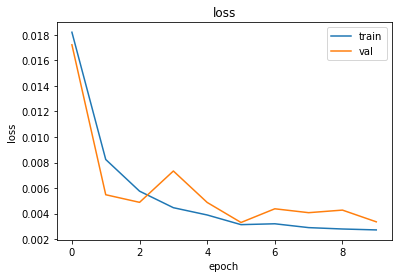

In [22]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

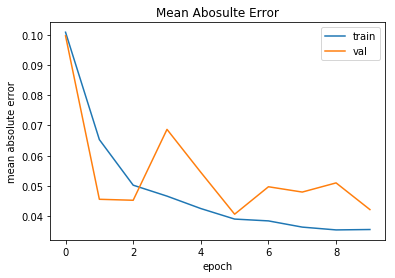

In [23]:
#import matplotlib.pyplot as pplot
pplot.plot(history.history['mean_absolute_error'])
pplot.plot(history.history['val_mean_absolute_error'])
pplot.title('Mean Abosulte Error')
pplot.xlabel('epoch')
pplot.ylabel('mean absolute error')
pplot.legend(['train','val'],loc='upper right')
pplot.show()

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

In [25]:
from IPython.display import Image

In [26]:
import pydot_ng as pydot
from IPython.display import Image

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

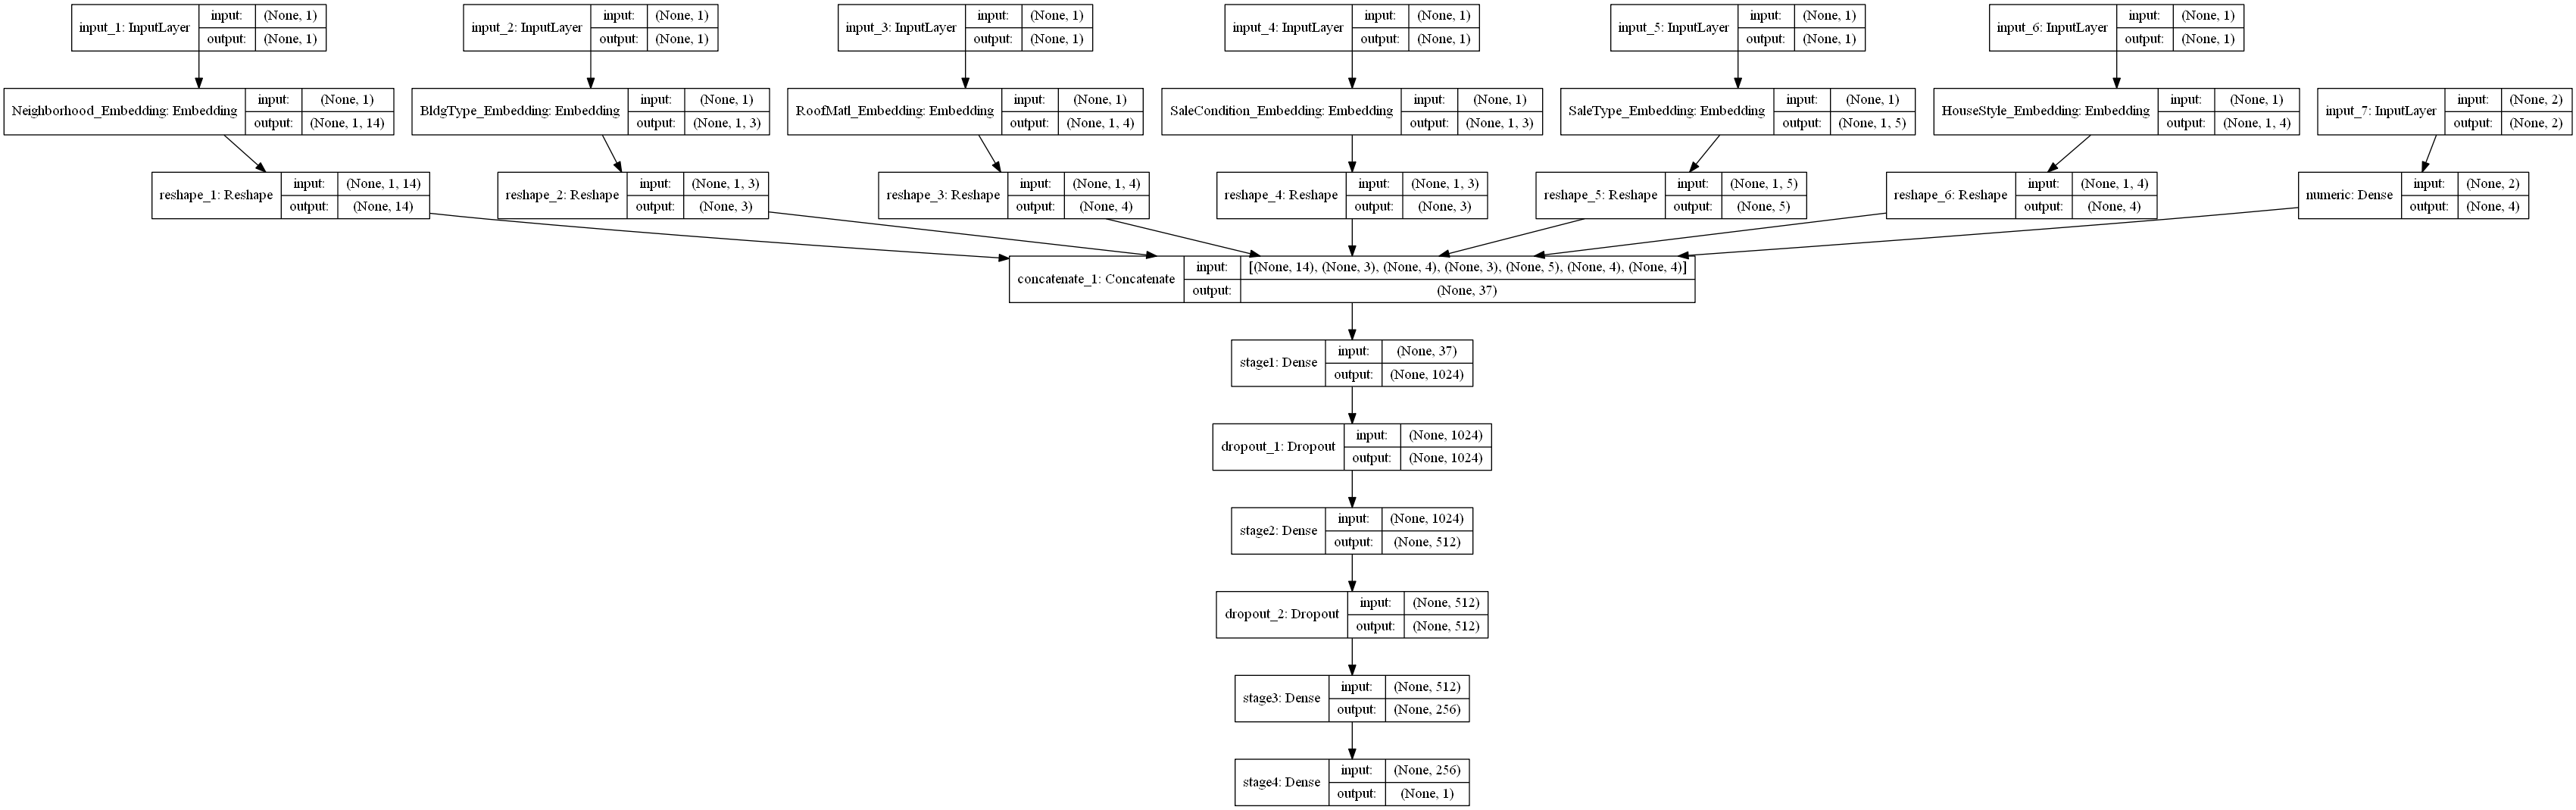

In [28]:
Image(retina=True, filename='model.png')